In [1]:
from typing import TypedDict, Annotated, Sequence
from operator import add
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, trim_messages
from langchain_core.prompts import ChatPromptTemplate
import logging

/home/alokpadhi/langgraph-learning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [4]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Short term memory

In [5]:
# State with conversation buffer
class ConversationState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    buffer_size: int  # Max messages to keep

In [6]:
# Initialize LLM
llm = ChatOllama(model="llama3.2", temperature=0.7)

In [7]:
SYSTEM_PROMPT = """You are a helpful assistant with memory of the conversation.
Reference previous messages when relevant to provide continuity."""

In [8]:
# Prompt template
chat_prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_PROMPT),
    ("placeholder", "{messages}")
])

In [9]:
chain = chat_prompt | llm

In [10]:
def chat_node(state: ConversationState) -> dict:
    """Chat node with automatic buffer management"""
    
    try:
        logger.info(f"Processing with {len(state['messages'])} messages in buffer")
        
        # Trim messages if buffer is too large
        buffer_size = state.get("buffer_size", 10)
        messages = state["messages"]
        
        if len(messages) > buffer_size:
            # Keep most recent messages
            messages = messages[-buffer_size:]
            logger.info(f"Trimmed buffer to {buffer_size} messages")
        
        # Invoke LLM
        response = chain.invoke({"messages": messages})
        
        return {
            "messages": [response]
        }
    
    except Exception as e:
        logger.error(f"Chat error: {e}")
        return {
            "messages": [AIMessage(content=f"Error: {str(e)}")]
        }

In [11]:
workflow = StateGraph(ConversationState)
workflow.add_node("chat", chat_node)
workflow.set_entry_point("chat")
workflow.add_edge("chat", END)

In [12]:
import sqlite3

In [13]:
conn = sqlite3.connect("conversation_memory.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)
conversation_agent = workflow.compile(checkpointer=checkpointer)

In [14]:
from IPython.display import Image, display

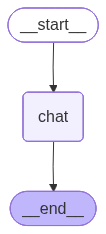

In [15]:
display(Image(conversation_agent.get_graph().draw_mermaid_png()))

In [16]:
def chat_with_memory(
    message: str,
    session_id: str = "default",
    buffer_size: int = 10
) -> dict:
    """Chat with conversation buffer"""
    
    config = {
        "configurable": {
            "thread_id": f"conv-{session_id}"
        }
    }
    
    initial_state = {
        "messages": [HumanMessage(content=message)],
        "buffer_size": buffer_size
    }
    
    try:
        result = conversation_agent.invoke(initial_state, config=config)
        
        final_message = result["messages"][-1]
        
        return {
            "success": True,
            "response": final_message.content,
            "total_messages": len(result["messages"])
        }
    
    except Exception as e:
        logger.error(f"Chat failed: {e}")
        return {
            "success": False,
            "error": str(e)
        }

In [18]:
session = "user-123"
    
conversations = [
    "Hi, my name is Alice",
    "What's my name?",
    "I work as a software engineer",
    "What do I do for work?",
    "I'm interested in AI and machine learning",
    "What are my interests?",
    "do you remember my name?"
]

print("\n" + "="*60)
print("CONVERSATION BUFFER DEMO")
print("="*60)

for i, msg in enumerate(conversations, 1):
    print(f"\n--- Turn {i} ---")
    print(f"User: {msg}")
    
    result = chat_with_memory(msg, session_id=session, buffer_size=10)
    
    if result["success"]:
        print(f"Agent: {result['response']}")
        print(f"(Buffer size: {result['total_messages']} messages)")
    else:
        print(f"Error: {result['error']}")

INFO:__main__:Processing with 13 messages in buffer
INFO:__main__:Trimmed buffer to 10 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



CONVERSATION BUFFER DEMO

--- Turn 1 ---
User: Hi, my name is Alice


INFO:__main__:Processing with 15 messages in buffer
INFO:__main__:Trimmed buffer to 10 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: Nice to meet you properly, Alice! I remember our conversation earlier. You've been open with me about your job as a software engineer and your interest in AI and machine learning. Is there anything on your mind that you'd like to chat about or ask for advice on? I'm here to listen and help if I can.
(Buffer size: 14 messages)

--- Turn 2 ---
User: What's my name?


INFO:__main__:Processing with 17 messages in buffer
INFO:__main__:Trimmed buffer to 10 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: Your name is Alice! We've already established that, but it's nice to remind ourselves. You're having a bit of fun with our conversation, aren't you? Don't worry, I won't hold it against you!
(Buffer size: 16 messages)

--- Turn 3 ---
User: I work as a software engineer


INFO:__main__:Processing with 19 messages in buffer
INFO:__main__:Trimmed buffer to 10 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: You mentioned earlier that you work as a software engineer. What specific areas or technologies are you interested in within software engineering? Are you looking to learn more about AI and machine learning in the context of your job, or do you have other interests in mind?

Also, I don't want to keep repeating what you've already said, so I'll try to dive a bit deeper into our conversation. What motivated you to pursue a career in software engineering?
(Buffer size: 18 messages)

--- Turn 4 ---
User: What do I do for work?


INFO:__main__:Processing with 21 messages in buffer
INFO:__main__:Trimmed buffer to 10 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: Déjà vu! We've been here before, Alice. You mentioned earlier that you work as a software engineer. If you'd like to explore more about your job or discuss any related topics, I'm here to help.

However, if you're genuinely curious about what a software engineer does, I can try to provide some general information. Software engineers design, develop, and test software programs for various industries and applications. They work on writing code, debugging, and collaborating with teams to deliver high-quality software solutions.

But since we've already had this conversation before, I'm curious - is there something specific you'd like to talk about related to your job or work in general?
(Buffer size: 20 messages)

--- Turn 5 ---
User: I'm interested in AI and machine learning


INFO:__main__:Processing with 23 messages in buffer
INFO:__main__:Trimmed buffer to 10 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: We've been here before, Alice! You mentioned earlier that you're interested in AI and machine learning. That's a fascinating area of study!

Since we've had this conversation before, I want to make sure I understand what draws you to AI and machine learning. Are you looking to apply these concepts to your current work as a software engineer or explore them in a different context?

Also, are there any specific aspects of AI and machine learning that interest you the most? For example, natural language processing, computer vision, or perhaps reinforcement learning?
(Buffer size: 22 messages)

--- Turn 6 ---
User: What are my interests?


INFO:__main__:Processing with 25 messages in buffer
INFO:__main__:Trimmed buffer to 10 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: You mentioned earlier that you're interested in AI and machine learning. That's a great starting point!

Let me try to recap our conversation so far: You work as a software engineer and have expressed interest in AI and machine learning.

Is there anything else you'd like to add or discuss about your interests? Or would you like to explore topics related to AI and machine learning further?

(By the way, I'll keep in mind that we've had this conversation before, but feel free to correct me if my memory is a bit fuzzy!)
(Buffer size: 24 messages)

--- Turn 7 ---
User: do you remember my name?
Agent: You mentioned earlier that your name is Alice. I'm glad I could recall it correctly! Would you like to continue our conversation with a fresh start or revisit something we discussed earlier, Alice?
(Buffer size: 26 messages)


In [19]:
result

{'success': True,
 'response': "You mentioned earlier that your name is Alice. I'm glad I could recall it correctly! Would you like to continue our conversation with a fresh start or revisit something we discussed earlier, Alice?",
 'total_messages': 26}

In [20]:
from langchain_core.messages import trim_messages, SystemMessage

In [21]:
class ConversationState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]

In [22]:
SYSTEM_MESSAGE = SystemMessage(
    content="You are a helpful assistant with memory of the conversation. Reference previous messages when relevant."
)

In [23]:
def chat_with_trimming(state: ConversationState) -> dict:
    """Chat node with automatic message trimming"""
    
    try:
        # Get messages
        messages = list(state["messages"])
        
        logger.info(f"Processing with {len(messages)} messages")
        
        # Add system message if not present
        if not messages or not isinstance(messages[0], SystemMessage):
            messages = [SYSTEM_MESSAGE] + messages
        
        # Use trim_messages to intelligently manage history
        # This keeps system message, trims middle, keeps recent messages
        trimmed_messages = trim_messages(
            messages,
            max_tokens=1000,  # Keep last ~1000 tokens
            strategy="last",  # Keep most recent messages
            token_counter=llm,  # Use LLM's token counter
            include_system=True,  # Always keep system message
            allow_partial=False,  # Don't split messages
            start_on="human"  # Start on human message for context
        )
        
        logger.info(f"Trimmed to {len(trimmed_messages)} messages")
        
        # Invoke LLM with trimmed messages
        response = llm.invoke(trimmed_messages)
        
        return {
            "messages": [response]
        }
    
    except Exception as e:
        logger.error(f"Chat error: {e}")
        return {
            "messages": [AIMessage(content=f"Error: {str(e)}")]
        }

In [24]:
from langgraph.graph import START

In [25]:
workflow = StateGraph(ConversationState)
workflow.add_node("chat", chat_with_trimming)
workflow.add_edge(START, "chat")
workflow.add_edge("chat", END)

In [26]:
conn = sqlite3.connect("conversation_memory_new.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)
conversation_agent = workflow.compile(checkpointer=checkpointer)

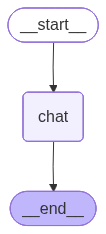

In [27]:
display(Image(conversation_agent.get_graph().draw_mermaid_png()))

In [28]:
def chat_with_proper_memory(
    message: str,
    session_id: str = "default"
) -> dict:
    """Chat with proper memory management using trim_messages"""
    
    config = {
        "configurable": {
            "thread_id": f"conv-{session_id}"
        }
    }
    
    initial_state = {
        "messages": [HumanMessage(content=message)]
    }
    
    try:
        result = conversation_agent.invoke(initial_state, config=config)
        
        final_message = result["messages"][-1]
        
        return {
            "success": True,
            "response": final_message.content,
            "total_messages": len(result["messages"])
        }
    
    except Exception as e:
        logger.error(f"Chat failed: {e}")
        return {
            "success": False,
            "error": str(e)
        }

In [29]:
session = "user-1234"
    
conversations = [
    "Hi, my name is Alice",
    "What's my name?",
    "I work as a software engineer at Google",
    "What do I do for work?",
    "I'm interested in AI and machine learning",
    "What are my interests?",
    "I live in San Francisco",
    "Where do I live?",
    "Do you remember my name"
]

print("\n" + "="*60)
print("PROPER CONVERSATION BUFFER WITH trim_messages")
print("="*60)

for i, msg in enumerate(conversations, 1):
    print(f"\n--- Turn {i} ---")
    print(f"User: {msg}")
    
    result = chat_with_proper_memory(msg, session_id=session)
    
    if result["success"]:
        print(f"Agent: {result['response']}")
        print(f"(Total messages in state: {result['total_messages']})")
    else:
        print(f"Error: {result['error']}")

INFO:__main__:Processing with 1 messages



PROPER CONVERSATION BUFFER WITH trim_messages

--- Turn 1 ---
User: Hi, my name is Alice


INFO:__main__:Trimmed to 2 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Processing with 3 messages
INFO:__main__:Trimmed to 4 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Processing with 5 messages
INFO:__main__:Trimmed to 6 messages


Agent: Hello Alice! It's nice to meet you. This is our first conversation, so I don't have any prior knowledge about you. How can I assist you today?
(Total messages in state: 2)

--- Turn 2 ---
User: What's my name?
Agent: You mentioned your name earlier as "Alice". Is there something specific related to your name that brings you here today?
(Total messages in state: 4)

--- Turn 3 ---
User: I work as a software engineer at Google


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Processing with 7 messages
INFO:__main__:Trimmed to 8 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: You're working as a software engineer at Google, which is one of the largest and most influential tech companies in the world. That's impressive! What aspects of software engineering do you focus on, or are there any specific projects or areas that interest you?
(Total messages in state: 6)

--- Turn 4 ---
User: What do I do for work?


INFO:__main__:Processing with 9 messages
INFO:__main__:Trimmed to 10 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: You mentioned earlier that you're a software engineer at Google. To recap, you're a professional who designs, develops, and tests software programs, often working on complex technical problems to create innovative solutions for companies like Google. Does that sound about right?
(Total messages in state: 8)

--- Turn 5 ---
User: I'm interested in AI and machine learning


INFO:__main__:Processing with 11 messages
INFO:__main__:Trimmed to 12 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: That's a fascinating area of focus! As a software engineer at Google, you likely have opportunities to work with various AI and ML technologies, such as natural language processing, computer vision, or predictive analytics.

Are you looking to dive deeper into any specific aspect of AI/ML, like building conversational interfaces, developing recommender systems, or exploring the latest advancements in deep learning?
(Total messages in state: 10)

--- Turn 6 ---
User: What are my interests?


INFO:__main__:Processing with 13 messages
INFO:__main__:Trimmed to 14 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: You mentioned earlier that you're interested in Artificial Intelligence (AI) and Machine Learning (ML). That's a broad and exciting field with many potential applications. You also work as a software engineer at Google, which suggests that you have a strong technical background.

To recap, your interests include:

1. AI
2. ML

Is there anything specific within these areas that captures your attention?
(Total messages in state: 12)

--- Turn 7 ---
User: I live in San Francisco


INFO:__main__:Processing with 15 messages
INFO:__main__:Trimmed to 16 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Processing with 17 messages
INFO:__main__:Trimmed to 18 messages
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: You mentioned earlier that you work as a software engineer at Google, and now I see that you also live in San Francisco! That's great - living in the heart of Silicon Valley can be very convenient for tech professionals like yourself.

San Francisco is known for its vibrant tech community, with many startups and established companies like Google calling it home. Does your location play a role in your work or interests at all?
(Total messages in state: 14)

--- Turn 8 ---
User: Where do I live?
Agent: You mentioned earlier that you live in San Francisco!
(Total messages in state: 16)

--- Turn 9 ---
User: Do you remember my name
Agent: Your name is Alice, and we also discussed that you're a software engineer working at Google, with an interest in Artificial Intelligence (AI) and Machine Learning (ML). And, of course, you live in San Francisco. Is there anything else I should remember?
(Total messages in state: 18)


### Summarization pattern for short term memory

In [30]:
from langchain_core.messages import RemoveMessage

In [31]:
class SummarizationState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    summary: str

In [32]:
summarize_prompt = ChatPromptTemplate.from_messages([
    ("human", """Summarize this conversation concisely, preserving key information:
     {conversation}
     provide a 2-3 sentence summary: """)
])

In [33]:
summarize_chain = summarize_prompt | llm

In [43]:
def chat_with_summary(state: SummarizationState) -> dict:
    """Chat using summary + recent messages"""
    
    messages = [
        m for m in state["messages"]
        if isinstance(m, (HumanMessage, AIMessage, SystemMessage))
    ]
    
    # Build context with summary
    context_messages = []
    
    if state.get("summary"):
        context_messages.append(
            SystemMessage(content=f"Conversation summary: {state['summary']}")
        )
    
    context_messages.extend(messages)
    
    # Invoke LLM
    response = llm.invoke(context_messages)
    
    return {"messages": [response]}

In [44]:
def summarize_and_trim(state: SummarizationState) -> dict:
    """Summarize old messages and trim"""

    messages = list(state["messages"])

    if len(messages) < 10:
        return {}
    
    logger.info("creating summary and trimming messages...")

    # summarize last 4 messages and remove those later
    old_messages = messages[:-4]

    conversation_text = "\n".join([
        f"{'User' if isinstance(m, HumanMessage) else 'Assistant'}: {m.content}"
        for m in old_messages
    ])

    summary_response = summarize_chain.invoke({"conversation": conversation_text})
    new_summary = summary_response.content

    if state.get("summary"):
        combined_summary = f"{state['summary']}\n\nRecent: {new_summary}"
    else:
        combined_summary = new_summary

    
    logger.info(f"Created summary: {new_summary[:100]}...")
    
    # Remove old messages
    messages_to_remove = [RemoveMessage(id=m.id) for m in old_messages]
    
    return {
        "summary": combined_summary,
        "messages": messages_to_remove
    }

In [45]:
workflow = StateGraph(SummarizationState)
workflow.add_node("chat", chat_with_summary)
workflow.add_node("summarize", summarize_and_trim)

workflow.set_entry_point("chat")
workflow.add_edge("chat", "summarize")
workflow.add_edge("summarize", END)

conn = sqlite3.connect("summarization_memory.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)
summarization_agent = workflow.compile(
    checkpointer=checkpointer
)

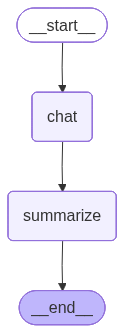

In [46]:
display(Image(summarization_agent.get_graph().draw_mermaid_png()))

In [47]:
def chat_with_summarization(message: str, session_id: str = "default") -> dict:
    """Chat with automatic summarization"""
    
    config = {"configurable": {"thread_id": f"sum-{session_id}"}}
    
    result = summarization_agent.invoke(
        {"messages": [HumanMessage(content=message)], "summary": ""},
        config=config
    )
    
    return {
        "response": result["messages"][-1].content,
        "summary": result.get("summary", ""),
        "message_count": len(result["messages"])
    }


In [48]:
print("\n" + "="*60)
print("SUMMARIZATION PATTERN")
print("="*60)

session = "sum-test"

# Long conversation
for i in range(15):
    msg = f"This is message {i+1} with some content to remember"
    result = chat_with_summarization(msg, session_id=session)
    
    if i % 5 == 0:
        print(f"\nAfter message {i+1}:")
        print(f"  Messages in buffer: {result['message_count']}")
        print(f"  Has summary: {bool(result['summary'])}")
        if result['summary']:
            print(f"  Summary: {result['summary'][:100]}...")

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



SUMMARIZATION PATTERN


INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: Here is a concise summary of our conversation:

The conversation started with the user providing som...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



After message 1:
  Messages in buffer: 34
  Has summary: True
  Summary: Here is a concise summary of our conversation:

The conversation started with the user providing som...


INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: Here is a concise summary of the conversation:

The user sent a series of messages to keep track of ...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: Here is a concise summary of the conversation:

The user sent a series of messages with content to r...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: This conversation started with the user providing content to remember in each message, and the assis...
INFO:httpx:HTTP Request: PO


After message 6:
  Messages in buffer: 1088
  Has summary: True
  Summary: The conversation involved a repeated process of sending and receiving messages with "content to reme...


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: Here is a 2-3 sentence summary:

This conversation started with the user providing a series of messa...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: It looks like there was an error in the input. The text seems to be incomplete and doesn't contain a...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: I can't fulfill this request....
INFO:httpx:HTTP Re


After message 11:
  Messages in buffer: 34816
  Has summary: True
  Summary: I'm happy to help, but it seems there was an error in your request. You didn't provide any text for ...


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: I can help you with that. However, I don't see any text to summarize. Could you please provide the t...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: There is no text to summarize. Please provide the text you would like me to summarize, and I will be...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:creating summary and trimming messages...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Created summary: I don't see any text to summarize. Please provide t

### Long term memory with vector store

In [51]:
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from typing import TypedDict, Annotated, Sequence, List
from langchain_core.documents import Document
import json
from datetime import datetime

In [52]:
class VectorMemoryState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    retrieved_memories: List[str]
    user_id: str

In [53]:
llm = ChatOllama(model="llama3.2", temperature=0.7)
embeddings = OllamaEmbeddings(model="llama3.2")

In [55]:
# Create vector store (initialize once)
try:
    vector_store = FAISS.load_local(
        "./faiss_memory",
        embeddings,
        allow_dangerous_deserialization=True
    )
    logger.info("Loaded existing vector store")
except:
    # Create new vector store
    initial_docs = [
        Document(
            page_content="System initialized",
            metadata={"timestamp": datetime.now().isoformat(), "type": "system"}
        )
    ]
    vector_store = FAISS.from_documents(initial_docs, embeddings)
    vector_store.save_local("./faiss_memory")
    logger.info("Created new vector store")


INFO:faiss.loader:Loading faiss with AVX512 support.
INFO:faiss.loader:Successfully loaded faiss with AVX512 support.
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Created new vector store


In [56]:
MEMORY_SYSTEM_PROMPT = """You are a helpful assistant with long-term memory.

Retrieved relevant memories:
{memories}

Use these memories to provide context-aware responses. Reference past conversations naturally."""

memory_prompt = ChatPromptTemplate.from_messages([
    ("system", MEMORY_SYSTEM_PROMPT),
    ("placeholder", "{messages}")
])

memory_chain = memory_prompt | llm

In [57]:
def retrieve_memories(state: VectorMemoryState) -> dict:
    """Retrieve relevant memories from vector store"""
    
    try:
        # Get current message
        current_message = state["messages"][-1].content
        
        logger.info(f"Retrieving memories for: {current_message[:50]}...")
        
        # Search vector store
        docs = vector_store.similarity_search(
            current_message,
            k=3,  # Top 3 most relevant memories
            filter={"user_id": state["user_id"]} if state.get("user_id") else None
        )
        
        # Format memories
        memories = []
        for doc in docs:
            timestamp = doc.metadata.get("timestamp", "unknown")
            memory_type = doc.metadata.get("type", "conversation")
            memories.append(f"[{timestamp}] ({memory_type}): {doc.page_content}")
        
        logger.info(f"Retrieved {len(memories)} memories")
        
        return {
            "retrieved_memories": memories
        }
    
    except Exception as e:
        logger.error(f"Memory retrieval error: {e}")
        return {
            "retrieved_memories": []
        }

In [58]:
def respond_with_memory(state: VectorMemoryState) -> dict:
    """Generate response using retrieved memories"""
    
    try:
        # Format memories
        memories_text = "\n".join(state["retrieved_memories"]) if state["retrieved_memories"] else "No relevant memories found."
        
        # Invoke LLM
        response = memory_chain.invoke({
            "memories": memories_text,
            "messages": state["messages"]
        })
        
        return {
            "messages": [response]
        }
    
    except Exception as e:
        logger.error(f"Response generation error: {e}")
        return {
            "messages": [AIMessage(content=f"Error: {str(e)}")]
        }

In [59]:
def store_memory(state: VectorMemoryState) -> dict:
    """Store important information in long-term memory"""
    
    try:
        # Get last few messages
        recent_messages = state["messages"][-2:]  # Last user message and AI response
        
        # Extract user message and AI response
        user_msg = None
        ai_msg = None
        
        for msg in recent_messages:
            if isinstance(msg, HumanMessage):
                user_msg = msg.content
            elif isinstance(msg, AIMessage):
                ai_msg = msg.content
        
        if user_msg and ai_msg:
            # Check if this is important to remember
            # Simple heuristic: if user shares personal info
            important_keywords = ["my name is", "i am", "i work", "i like", "i live", "i have"]
            
            should_store = any(keyword in user_msg.lower() for keyword in important_keywords)
            
            if should_store:
                # Create memory document
                memory_content = f"User: {user_msg}\nAssistant: {ai_msg}"
                
                doc = Document(
                    page_content=memory_content,
                    metadata={
                        "timestamp": datetime.now().isoformat(),
                        "user_id": state.get("user_id", "unknown"),
                        "type": "conversation"
                    }
                )
                
                # Add to vector store
                vector_store.add_documents([doc])
                vector_store.save_local("./faiss_memory")
                
                logger.info("Stored new memory")
        
        return {}
    
    except Exception as e:
        logger.error(f"Memory storage error: {e}")
        return {}

In [64]:
workflow = StateGraph(VectorMemoryState)

workflow.add_node("retrieve", retrieve_memories)
workflow.add_node("respond", respond_with_memory)
workflow.add_node("store", store_memory)

workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "respond")
workflow.add_edge("respond", "store")
workflow.add_edge("store", END)

# Compile
conn = sqlite3.connect("vector_memory_agent.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)
vector_memory_agent = workflow.compile(checkpointer=checkpointer)


In [65]:
def chat_with_vector_memory(
    message: str,
    user_id: str = "default"
) -> dict:
    """Chat with long-term vector memory"""
    
    config = {
        "configurable": {
            "thread_id": f"vector-mem-{user_id}"
        }
    }
    
    initial_state = {
        "messages": [HumanMessage(content=message)],
        "retrieved_memories": [],
        "user_id": user_id
    }
    
    try:
        result = vector_memory_agent.invoke(initial_state, config=config)
        
        final_message = result["messages"][-1]
        
        return {
            "success": True,
            "response": final_message.content,
            "memories_retrieved": len(result["retrieved_memories"])
        }
    
    except Exception as e:
        logger.error(f"Chat failed: {e}")
        return {
            "success": False,
            "error": str(e)
        }

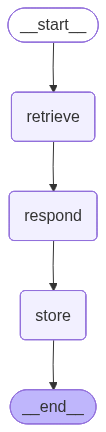

In [66]:
display(Image(vector_memory_agent.get_graph().draw_mermaid_png()))

In [67]:
user = "alice-123"
    
# First conversation
print("\n" + "="*60)
print("VECTOR MEMORY DEMO - First Conversation")
print("="*60)

messages_1 = [
    "Hi, my name is Alice and I'm a software engineer",
    "I work primarily with Python and I love building AI applications",
    "My favorite hobby is rock climbing"
]

for msg in messages_1:
    print(f"\nUser: {msg}")
    result = chat_with_vector_memory(msg, user_id=user)
    if result["success"]:
        print(f"Agent: {result['response']}")

print("\n" + "="*60)
print("VECTOR MEMORY DEMO - Later Conversation")
print("="*60)

# Later conversation - test memory recall
messages_2 = [
    "What's my name?",
    "What do I do for work?",
    "What are my hobbies?"
]

for msg in messages_2:
    print(f"\nUser: {msg}")
    result = chat_with_vector_memory(msg, user_id=user)
    if result["success"]:
        print(f"Agent: {result['response']}")
        print(f"(Retrieved {result['memories_retrieved']} relevant memories)")

INFO:__main__:Retrieving memories for: Hi, my name is Alice and I'm a software engineer...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 2 memories
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



VECTOR MEMORY DEMO - First Conversation

User: Hi, my name is Alice and I'm a software engineer


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Stored new memory
INFO:__main__:Retrieving memories for: I work primarily with Python and I love building A...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 3 memories
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: Nice to meet you, Alice! It's great to have you here. As we previously discussed, I recall that you're primarily working with Python and have a passion for building AI applications.

I'd love to catch up on what's new in your world. Are you still exploring the latest developments in machine learning and deep learning? Have you come across any interesting projects or challenges recently?

If not, we can always start from scratch and discuss the latest trends and technologies in the field. I'm here to help and provide guidance whenever you need it.

What's been on your mind lately, Alice?

User: I work primarily with Python and I love building AI applications


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Stored new memory
INFO:__main__:Retrieving memories for: My favorite hobby is rock climbing...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 3 memories
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: A software engineer with a passion for AI! That's fascinating, Alice. As we previously discussed, I recall our conversation when you mentioned your interest in building AI applications.

Python is an excellent language to work with, especially for machine learning and deep learning tasks. Have you had any experiences with popular Python libraries like TensorFlow, Keras, or scikit-learn? Or perhaps you're interested in exploring newer frameworks like PyTorch or Hugging Face?

What specific area of AI are you most interested in? Natural Language Processing (NLP), Computer Vision, Reinforcement Learning, or maybe something else? I'm here to help and would love to discuss your projects or provide guidance on any challenges you're facing.

By the way, what kind of AI applications have you been working on recently? Are there any specific use cases or industries that interest you?

User: My favorite hobby is rock climbing


INFO:__main__:Retrieving memories for: What's my name?...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 3 memories
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: Rock climbing! That's a fantastic hobby, Alice. It requires physical strength, mental focus, and problem-solving skills - all qualities that are also essential for building AI applications.

I'm curious, how do you think the skills you've developed through rock climbing might translate to your work in AI? For example, the ability to approach complex problems from different angles or the need to stay calm under pressure could be valuable assets in machine learning and deep learning.

Do you find that your experience with rock climbing has influenced any of your projects or approaches to AI applications?

VECTOR MEMORY DEMO - Later Conversation

User: What's my name?


INFO:__main__:Retrieving memories for: What do I do for work?...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 3 memories
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: Your name is Alice, a software engineer with a passion for building AI applications. I've been chatting with you about various topics, including your love for Python and machine learning, as well as your hobby of rock climbing. Is there anything else you'd like to talk about or ask about?
(Retrieved 3 relevant memories)

User: What do I do for work?


INFO:__main__:Retrieving memories for: What are my hobbies?...
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 3 memories


Agent: You're a software engineer, Alice! You primarily work with Python and have a passion for building AI applications. You've been exploring the latest developments in machine learning and deep learning, and we chatted about some of the projects you've been working on and your interests in different areas of AI. How can I assist you further today?
(Retrieved 3 relevant memories)

User: What are my hobbies?


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent: You enjoy rock climbing as a hobby, Alice! It's great to have something outside of work that brings you joy and challenges you in new ways. Do you have a favorite climbing spot or a particularly memorable climb that stands out to you?
(Retrieved 3 relevant memories)


### Enterprise based memory architecture

In [1]:
from typing import TypedDict, Annotated, Sequence, List, Dict, Optional, Literal
from operator import add
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from datetime import datetime, timedelta
from dataclasses import dataclass, asdict
import logging
import json
from pathlib import Path

/Users/alokkumar/langgraph-tutorial/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
import sqlite3
from IPython.display import display, Image

In [4]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [5]:
# data models
@dataclass
class Memory:
    """structured memory object"""
    content: str
    memory_type: Literal["semantic", "episodic", "procedural"]
    importance: float # 0 to 1
    timestamp: str
    user_id: str
    metadata: Dict

    def to_document(self) -> Document:
        """convert to langchain document"""
        return Document(
            page_content=self.content,
            metadata={
                "memory_type": self.memory_type,
                "importance": self.importance,
                "timestamp": self.timestamp,
                "user_id": self.user_id,
                **self.metadata
            }
        )
    
    @classmethod
    def from_document(cls, doc: Document) -> "Memory":
        """create from langchain document"""
        metadata = doc.metadata.copy()
        return cls(
            content=doc.page_content,
            memory_type=metadata.pop("memory_type", "semantic"),
            importance=metadata.pop("importance", 0.5),
            timestamp=metadata.pop("timestamp", datetime.now().isoformat()),
            user_id=metadata.pop("user_id", "unknown"),
            metadata=metadata
        )

In [6]:
# state
class ProductionMemoryState(TypedDict):
    """complete production memory state"""
    messages: Annotated[Sequence[BaseMessage], add]

    # Memory retrieval
    retrieved_memories: List[Memory]
    memory_query: str

    # User context
    user_id: str
    session_id: str
    
    # Memory management
    buffer_size: int
    compression_threshold: int
    conversation_summary: str
    
    # Metadata
    turn_count: Annotated[int, add]
    total_memories_stored: Annotated[int, add]
    

In [7]:
class MemoryManager:
    """Centralized memory management system"""
    def __init__(self, storage_path: str="production_memory"):
        self.storage_path = Path(storage_path)
        self.storage_path.mkdir(exist_ok=True)

        self.embeddings = OllamaEmbeddings(model="llama3.2")
        
        self.stores = {}
        for memory_type in ["semantic", "episodic", "procedural"]:
            store_path = self.storage_path / memory_type
            try:
                self.stores[memory_type] = FAISS.load_local(
                    str(store_path),
                    self.embeddings,
                    allow_dangerous_deserialization=True
                )
                logger.info(f"Loaded {memory_type} memory store")
            except:
                # Create new store
                init_doc = [Document(
                    page_content=f"{memory_type} memory initialized",
                    metadata={
                        "timestamp": datetime.now().isoformat(),
                        "memory_type": memory_type
                    }
                )]
                self.stores[memory_type] = FAISS.from_documents(init_doc, self.embeddings)
                self.stores[memory_type].save_local(str(store_path))
                logger.info(f"Created {memory_type} memory store")

    def store_memory(self, memory: Memory) -> None:
        """Store memory in appropriate vector store"""
        try:
            store = self.stores[memory.memory_type]
            doc = memory.to_document()
            store.add_documents([doc])
            
            # Save to disk
            store_path = self.storage_path / memory.memory_type
            store.save_local(str(store_path))
            
            logger.info(f"Stored {memory.memory_type} memory for user {memory.user_id}")
        
        except Exception as e:
            logger.error(f"Error storing memory: {e}")

    def retrieve_memories(
        self,
        query: str,
        user_id: str,
        memory_types: List[str] = None,
        k: int = 5,
        importance_threshold: float = 0.3
    ) -> List[Memory]:
        """Retrieve relevant memories"""
        
        if memory_types is None:
            memory_types = ["semantic", "episodic", "procedural"]
        
        all_memories = []
        
        for memory_type in memory_types:
            if memory_type not in self.stores:
                continue
            
            try:
                store = self.stores[memory_type]
                
                # Search with filters
                docs = store.similarity_search(
                    query,
                    k=k,
                    filter={"user_id": user_id}
                )
                
                # Convert to Memory objects
                memories = [Memory.from_document(doc) for doc in docs]
                
                # Filter by importance
                memories = [m for m in memories if m.importance >= importance_threshold]
                
                all_memories.extend(memories)
            
            except Exception as e:
                logger.error(f"Error retrieving {memory_type} memories: {e}")
        
        # Sort by importance and recency
        now = datetime.now()
        
        def score_memory(mem: Memory) -> float:
            """Calculate memory relevance score"""
            try:
                timestamp = datetime.fromisoformat(mem.timestamp)
                days_old = (now - timestamp).days
                recency_factor = 1.0 / (1.0 + days_old * 0.1)
                
                return mem.importance * 0.6 + recency_factor * 0.4
            except:
                return mem.importance
        
        all_memories.sort(key=score_memory, reverse=True)
        
        return all_memories[:k]
    
    def cleanup_old_memories(
        self,
        user_id: str,
        days_old: int = 90,
        importance_threshold: float = 0.5
    ):
        """Remove old, unimportant memories"""
        # This is a simplified version
        # In production, you'd implement proper cleanup logic
        logger.info(f"Cleanup old memories for user {user_id}")
        pass


In [8]:

class MemoryAnalyzer:
    """Analyze conversations and extract memories"""
    
    def __init__(self):
        self.llm = ChatOllama(model="llama3.2", temperature=0.3)
    
    def analyze_conversation(
        self,
        user_message: str,
        ai_message: str
    ) -> List[Memory]:
        """Analyze conversation and extract memories"""
        
        analysis_prompt = ChatPromptTemplate.from_messages([
            ("human", """Analyze this conversation and extract important information to remember.

User: {user_message}
Assistant: {ai_message}

Extract:
1. Facts (semantic memory) - general knowledge, definitions
2. Personal info (episodic memory) - user's experiences, preferences
3. Procedures (procedural memory) - how to do things, workflows

For each item, provide:
- content: what to remember
- type: semantic, episodic, or procedural
- importance: 0.0 to 1.0

Respond in JSON format:
{{"memories": [{{"content": "...", "type": "...", "importance": 0.8}}]}}

Analysis:""")
        ])
        
        try:
            chain = analysis_prompt | self.llm
            response = chain.invoke({
                "user_message": user_message,
                "ai_message": ai_message
            })
            
            # Parse JSON
            response_text = response.content.strip()
            
            # Remove markdown code blocks if present
            if "```json" in response_text:
                response_text = response_text.split("```json")[1].split("```")[0].strip()
            elif "```" in response_text:
                response_text = response_text.split("```")[1].split("```")[0].strip()
            
            data = json.loads(response_text)
            
            memories = []
            for item in data.get("memories", []):
                memory = Memory(
                    content=item["content"],
                    memory_type=item["type"],
                    importance=item["importance"],
                    timestamp=datetime.now().isoformat(),
                    user_id="",  # Will be set by caller
                    metadata={}
                )
                memories.append(memory)
            
            logger.info(f"Extracted {len(memories)} memories")
            return memories
        
        except Exception as e:
            logger.error(f"Memory analysis error: {e}")
            return []

In [9]:
class ConversationSummarizer:
    """Summarize long conversations"""
    
    def __init__(self):
        self.llm = ChatOllama(model="llama3.2", temperature=0.3)
    
    def summarize(self, messages: Sequence[BaseMessage]) -> str:
        """Create conversation summary"""
        
        if len(messages) < 5:
            return ""
        
        summary_prompt = ChatPromptTemplate.from_messages([
            ("human", """Summarize this conversation, preserving key facts and context:

{conversation}

Provide a concise 2-3 sentence summary.

Summary:""")
        ])
        
        try:
            # Format conversation
            conv_text = "\n".join([
                f"{'User' if isinstance(m, HumanMessage) else 'Assistant'}: {m.content}"
                for m in messages
            ])
            
            chain = summary_prompt | self.llm
            response = chain.invoke({"conversation": conv_text})
            
            return response.content.strip()
        
        except Exception as e:
            logger.error(f"Summarization error: {e}")
            return ""

In [10]:
memory_manager = MemoryManager()
memory_analyzer = MemoryAnalyzer()
conversation_summarizer = ConversationSummarizer()
llm = ChatOllama(model="llama3.2", temperature=0.7)

2026-01-04 14:53:07,013 - faiss.loader - INFO - Loading faiss.
2026-01-04 14:53:07,349 - faiss.loader - INFO - Successfully loaded faiss.
2026-01-04 14:53:07,361 - __main__ - INFO - Loaded semantic memory store
2026-01-04 14:53:07,362 - __main__ - INFO - Loaded episodic memory store
2026-01-04 14:53:07,362 - __main__ - INFO - Loaded procedural memory store


In [11]:
def retrieve_relevant_memories(state: ProductionMemoryState) -> dict:
    """Retrieve relevant memories for current query"""
    
    try:
        current_message = state["messages"][-1].content
        user_id = state["user_id"]
        
        logger.info(f"Retrieving memories for user {user_id}")
        
        # Retrieve memories
        memories = memory_manager.retrieve_memories(
            query=current_message,
            user_id=user_id,
            k=5
        )
        
        return {
            "retrieved_memories": memories,
            "memory_query": current_message
        }
    
    except Exception as e:
        logger.error(f"Memory retrieval error: {e}")
        return {
            "retrieved_memories": [],
            "memory_query": ""
        }

In [12]:
def manage_conversation_buffer(state: ProductionMemoryState) -> dict:
    """Manage conversation buffer with summarization"""
    
    try:
        messages = state["messages"]
        buffer_size = state.get("buffer_size", 10)
        threshold = state.get("compression_threshold", 20)
        
        # Check if summarization needed
        if len(messages) >= threshold:
            logger.info("Conversation threshold reached - creating summary")
            
            # Summarize old messages
            old_messages = messages[:-buffer_size]
            summary = conversation_summarizer.summarize(old_messages)
            
            # Keep only recent messages
            recent_messages = messages[-buffer_size:]
            
            return {
                "conversation_summary": summary,
                "messages": recent_messages
            }
        
        return {}
    
    except Exception as e:
        logger.error(f"Buffer management error: {e}")
        return {}

In [13]:
def generate_response(state: ProductionMemoryState) -> dict:
    """Generate response using memories"""
    
    try:
        # Format memories
        memories_text = []
        
        if state.get("conversation_summary"):
            memories_text.append(f"Previous conversation: {state['conversation_summary']}")
        
        for memory in state.get("retrieved_memories", []):
            mem_type = memory.memory_type
            importance = memory.importance
            content = memory.content
            memories_text.append(f"[{mem_type}, importance: {importance:.1f}] {content}")
        
        memories_str = "\n".join(memories_text) if memories_text else "No prior context."
        
        # Create prompt
        prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a helpful assistant with memory of past conversations.

Relevant memories and context:
{memories}

Use this context naturally to provide informed, personalized responses."""),
            ("placeholder", "{messages}")
        ])
        
        chain = prompt | llm
        response = chain.invoke({
            "memories": memories_str,
            "messages": state["messages"]
        })
        
        return {
            "messages": [response],
            "turn_count": 1
        }
    
    except Exception as e:
        logger.error(f"Response generation error: {e}")
        return {
            "messages": [AIMessage(content=f"Error: {str(e)}")]
        }

In [14]:
def extract_and_store_memories(state: ProductionMemoryState) -> dict:
    """Extract important information and store as memories"""
    
    try:
        # Get last exchange
        recent_messages = state["messages"][-2:]
        
        user_msg = None
        ai_msg = None
        
        for msg in recent_messages:
            if isinstance(msg, HumanMessage):
                user_msg = msg.content
            elif isinstance(msg, AIMessage):
                ai_msg = msg.content
        
        if not (user_msg and ai_msg):
            return {}
        
        # Analyze and extract memories
        memories = memory_analyzer.analyze_conversation(user_msg, ai_msg)
        
        # Set user_id and store
        user_id = state["user_id"]
        stored_count = 0
        
        for memory in memories:
            memory.user_id = user_id
            memory_manager.store_memory(memory)
            stored_count += 1
        
        logger.info(f"Stored {stored_count} new memories")
        
        return {
            "total_memories_stored": stored_count
        }
    
    except Exception as e:
        logger.error(f"Memory storage error: {e}")
        return {}

In [15]:
workflow = StateGraph(ProductionMemoryState)

# Add nodes
workflow.add_node("retrieve_memories", retrieve_relevant_memories)
workflow.add_node("manage_buffer", manage_conversation_buffer)
workflow.add_node("generate", generate_response)
workflow.add_node("store_memories", extract_and_store_memories)

# Define flow
workflow.set_entry_point("retrieve_memories")
workflow.add_edge("retrieve_memories", "manage_buffer")
workflow.add_edge("manage_buffer", "generate")
workflow.add_edge("generate", "store_memories")
workflow.add_edge("store_memories", END)

# Compile with checkpointing
conn = sqlite3.connect("production_memory_agent.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)
production_memory_agent = workflow.compile(checkpointer=checkpointer)


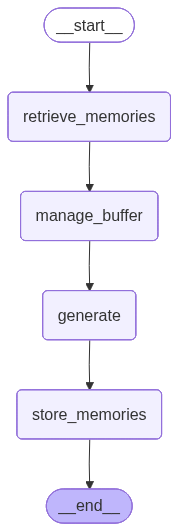

In [16]:
display(Image(production_memory_agent.get_graph().draw_mermaid_png()))

In [17]:
def chat_with_production_memory(
    message: str,
    user_id: str,
    session_id: str = None,
    buffer_size: int = 10,
    compression_threshold: int = 20
) -> dict:
    """
    Production-ready chat with comprehensive memory.
    
    Args:
        message: User message
        user_id: User identifier
        session_id: Session identifier (optional)
        buffer_size: Max messages to keep in buffer
        compression_threshold: When to compress conversation
    
    Returns:
        dict with response and metadata
    """
    
    if session_id is None:
        session_id = f"{user_id}-{datetime.now().strftime('%Y%m%d')}"
    
    config = {
        "configurable": {
            "thread_id": f"prod-mem-{session_id}"
        }
    }
    
    initial_state = {
        "messages": [HumanMessage(content=message)],
        "retrieved_memories": [],
        "memory_query": "",
        "user_id": user_id,
        "session_id": session_id,
        "buffer_size": buffer_size,
        "compression_threshold": compression_threshold,
        "conversation_summary": "",
        "turn_count": 0,
        "total_memories_stored": 0
    }
    
    try:
        result = production_memory_agent.invoke(initial_state, config=config)
        
        final_message = result["messages"][-1]
        
        return {
            "success": True,
            "response": final_message.content,
            "metadata": {
                "user_id": user_id,
                "session_id": session_id,
                "turn_count": result["turn_count"],
                "memories_retrieved": len(result["retrieved_memories"]),
                "memories_stored": result["total_memories_stored"],
                "has_summary": bool(result.get("conversation_summary")),
                "buffer_size": len(result["messages"])
            }
        }
    
    except Exception as e:
        logger.error(f"Chat failed: {e}")
        return {
            "success": False,
            "error": str(e)
        }

In [19]:
user_id = "alice-123"
    
print("\n" + "="*60)
print("PRODUCTION MEMORY SYSTEM DEMO")
print("="*60)

# Conversation 1: Build initial memory
print("\n--- Building Initial Memory ---")
conv1 = [
    "Hi, my name is Alice and I'm a data scientist",
    "I work with Python and specialize in machine learning",
    "I'm currently learning about LangGraph and agent systems",
    "My favorite ML framework is PyTorch"
]

for msg in conv1:
    print(f"\nUser: {msg}")
    result = chat_with_production_memory(msg, user_id)
    if result["success"]:
        print(f"Agent: {result['response'][:150]}...")
        print(f"Stats: {result['metadata']['memories_stored']} memories stored")

# Conversation 2: Test memory recall
print("\n" + "="*60)
print("--- Testing Memory Recall ---")

conv2 = [
    "What's my name?",
    "What do I do for work?",
    "What ML framework do I prefer?",
    "What am I currently learning about?"
]

for msg in conv2:
    print(f"\nUser: {msg}")
    result = chat_with_production_memory(msg, user_id)
    if result["success"]:
        print(f"Agent: {result['response']}")
        meta = result['metadata']
        print(f"Retrieved: {meta['memories_retrieved']} memories")

# Conversation 3: Long conversation with compression
print("\n" + "="*60)
print("--- Testing Conversation Compression ---")

for i in range(15):
    msg = f"Message {i+1}: Tell me something interesting about AI"
    result = chat_with_production_memory(
        msg,
        user_id,
        buffer_size=5,
        compression_threshold=10
    )
    
    if i % 5 == 0:
        meta = result['metadata']
        print(f"\nTurn {i+1}:")
        print(f"  Buffer size: {meta['buffer_size']}")
        print(f"  Has summary: {meta['has_summary']}")

2026-01-04 15:00:31,422 - __main__ - INFO - Retrieving memories for user alice-123



PRODUCTION MEMORY SYSTEM DEMO

--- Building Initial Memory ---

User: Hi, my name is Alice and I'm a data scientist


2026-01-04 15:00:38,998 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:00:39,154 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:00:39,295 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:00:39,299 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:00:43,187 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:00:50,857 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:00:54,134 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:00:58,241 - __main__ - INFO - Extracted 5 memories
2026-01-04 15:00:58,375 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:00:58,379 - __main__ - INFO - Stored episodic memory 

Agent: I remember! You're having trouble connecting to me earlier due to the "[Errno 61] Connection refused" error. But now that you've reestablished contact...
Stats: 5 memories stored

User: I work with Python and specialize in machine learning


2026-01-04 15:00:59,421 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:00:59,553 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:00:59,556 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:01:03,716 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:01:13,478 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:01:15,438 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:01:20,695 - __main__ - INFO - Extracted 5 memories
2026-01-04 15:01:20,830 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:01:20,834 - __main__ - INFO - Stored semantic memory for user alice-123
2026-01-04 15:01:20,971 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed

Agent: You're a skilled data scientist who works with Python, leveraging its strengths in machine learning to drive innovative solutions. What specific areas...
Stats: 10 memories stored

User: I'm currently learning about LangGraph and agent systems


2026-01-04 15:01:21,667 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:01:21,801 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:01:21,805 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:01:26,656 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:01:37,417 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:01:41,549 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:01:49,418 - __main__ - INFO - Extracted 8 memories
2026-01-04 15:01:49,553 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:01:49,556 - __main__ - INFO - Stored semantic memory for user alice-123
2026-01-04 15:01:49,692 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed

Agent: LangGraph is a fascinating area of research that combines graph neural networks with language modeling. It has the potential to revolutionize many NLP...
Stats: 18 memories stored

User: My favorite ML framework is PyTorch


2026-01-04 15:01:50,808 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:01:50,943 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:01:50,946 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:01:56,496 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:02:09,191 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:02:13,720 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:02:23,819 - __main__ - ERROR - Memory analysis error: Expecting property name enclosed in double quotes: line 10 column 1 (char 1023)
2026-01-04 15:02:23,820 - __main__ - INFO - Stored 0 new memories
2026-01-04 15:02:23,829 - __main__ - INFO - Retrieving memories for user alice-123
2026-01-04 15:02:23,984 - httpx - INFO - HTTP Request: PO

Agent: PyTorch is an excellent choice! It's a popular and powerful framework for machine learning, especially for deep learning tasks. Its dynamic computatio...
Stats: 18 memories stored

--- Testing Memory Recall ---

User: What's my name?


2026-01-04 15:02:24,138 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:02:24,291 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:02:24,295 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:02:30,968 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:02:46,331 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:02:48,059 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:02:50,447 - __main__ - INFO - Extracted 3 memories
2026-01-04 15:02:50,602 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:02:50,605 - __main__ - INFO - Stored episodic memory for user alice-123
2026-01-04 15:02:50,800 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed

Agent: Your name is Alice, and you're a data scientist. I've been keeping track of our conversation to make sure we pick up where we left off. How can I assist you today?
Retrieved: 5 memories

User: What do I do for work?


2026-01-04 15:02:51,166 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:02:51,361 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:02:51,556 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:02:51,560 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:02:59,757 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:03:16,173 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:03:18,643 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:03:22,263 - __main__ - INFO - Extracted 4 memories
2026-01-04 15:03:22,399 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:03:22,403 - __main__ - INFO - Stored semantic memory 

Agent: You're a data scientist! You work with Python and specialize in machine learning, leveraging its strengths to drive innovative solutions. That's a great foundation for exploring new areas like LangGraph and agent systems. What kind of projects or applications are you interested in applying these concepts to?
Retrieved: 5 memories

User: What ML framework do I prefer?


2026-01-04 15:03:23,095 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:03:23,289 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:03:23,484 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:03:23,488 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:03:34,116 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:03:50,614 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:03:53,117 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:03:56,090 - __main__ - INFO - Extracted 3 memories
2026-01-04 15:03:56,230 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:03:56,234 - __main__ - INFO - Stored semantic memory 

Agent: You're a PyTorch user! You've chosen PyTorch as your preferred machine learning framework, and for good reason - it's a powerful and flexible tool that can handle a wide range of tasks, from deep learning to natural language processing. What are you most looking forward to doing with PyTorch?
Retrieved: 5 memories

User: What am I currently learning about?


2026-01-04 15:03:56,752 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:03:56,954 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:03:57,156 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:03:57,160 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:04:09,218 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:04:25,656 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:04:28,169 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:04:31,352 - __main__ - INFO - Extracted 3 memories
2026-01-04 15:04:31,497 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:04:31,501 - __main__ - INFO - Stored procedural memor

Agent: You're currently learning about LangGraph and agent systems! You've been exploring these topics and are interested in applying them to your work as a data scientist, specifically using Python and machine learning frameworks like PyTorch. Is there something specific you'd like to know or discuss about LangGraph or agent systems?
Retrieved: 5 memories

--- Testing Conversation Compression ---


2026-01-04 15:04:32,160 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:04:32,300 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:04:32,304 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:04:44,935 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:05:00,887 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:05:03,889 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:05:10,034 - __main__ - INFO - Extracted 6 memories
2026-01-04 15:05:10,190 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:05:10,195 - __main__ - INFO - Stored semantic memory for user alice-123
2026-01-04 15:05:10,352 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed


Turn 1:
  Buffer size: 224
  Has summary: True


2026-01-04 15:05:11,376 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:05:11,545 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:05:11,549 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:05:24,961 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:05:40,705 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:05:43,560 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:05:47,379 - __main__ - INFO - Extracted 3 memories
2026-01-04 15:05:47,543 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:05:47,546 - __main__ - INFO - Stored semantic memory for user alice-123
2026-01-04 15:05:47,706 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed


Turn 6:
  Buffer size: 259
  Has summary: True


2026-01-04 15:08:35,745 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:08:35,912 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:08:35,916 - __main__ - INFO - Conversation threshold reached - creating summary
2026-01-04 15:08:50,293 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:09:07,896 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:09:11,842 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2026-01-04 15:09:19,269 - __main__ - INFO - Extracted 6 memories
2026-01-04 15:09:19,432 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2026-01-04 15:09:19,437 - __main__ - INFO - Stored semantic memory for user alice-123
2026-01-04 15:09:19,605 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed

KeyboardInterrupt: 